<a href="https://colab.research.google.com/github/Naveenand/Instruction-Finetuning-LLM/blob/main/Gpt2_medium_on_sql_create_context(Instruction%20fine-tuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig
!pip install ludwig[llm]

In [ ]:
!pip install transformers datasets

In [ ]:
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
dataset = load_dataset('b-mc2/sql-create-context')

In [ ]:
data = dataset['train'].shuffle().select(range(5000))

In [ ]:
data.push_to_hub("Naveengo/sql-create-context-5000rows")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
data.push_to_Hub

In [ ]:
data = pd.DataFrame(data)

In [ ]:
data.head(5)

,question,answer,context
0,What place did Bob May get when his score was ...,SELECT place FROM table_name_84 WHERE score = ...,"CREATE TABLE table_name_84 (place VARCHAR, pla..."
1,What is the latest episode number with the tit...,SELECT MAX(episode__number) FROM table_1951762...,CREATE TABLE table_19517621_4 (episode__number...
2,Which Game is the highest one that has a Recor...,SELECT MAX(game) FROM table_name_83 WHERE reco...,"CREATE TABLE table_name_83 (game INTEGER, reco..."
3,In what year did Aslan receive a Lifetime Achi...,"SELECT year FROM table_name_56 WHERE band = ""s...","CREATE TABLE table_name_56 (year VARCHAR, band..."
4,When was the most recent year that kathy whitw...,SELECT MAX(year) FROM table_name_49 WHERE runn...,"CREATE TABLE table_name_49 (year INTEGER, runn..."


Average number of tokens in the instruction column: 24
Average number of tokens in the input column: 20
Average number of tokens in the output column: 25



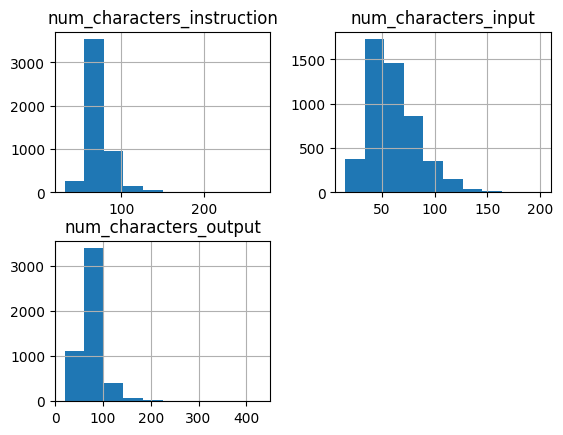

In [ ]:
# Calculating the length of each cell in each column
data['num_characters_instruction'] = data['context'].apply(lambda x: len(x))
data['num_characters_input'] = data['question'].apply(lambda x: len(x))
data['num_characters_output'] = data['answer'].apply(lambda x: len(x))

# Show Distribution
data.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = data['num_characters_instruction'].mean()
average_chars_input = data['num_characters_input'].mean()
average_chars_output = data['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

In [ ]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM

# Replace with your T5 model name
model_name = "gpt2-large"

# Load the T5 model
#config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


In [ ]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: gpt2-medium

input_features:
  - name: question
    type: text

output_features:
  - name: answer
    type: text

prompt:
  template: >-
    Below is an SQL instruction that describes a task,
    paired with an input that provides further context.
    Write an SQL query that appropriately completes the request using your expertise in SQL.

    ### Instruction: {question}

    ### Input: {context}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length:512
  split:
    type: random
    probabilities:
    - 0.8
    - 0.1
    - 0.1

trainer:
  type: finetune
  epochs: 5
  batch_size: 5
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

In [ ]:
model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)

In [ ]:
results = model.train(dataset=data)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_2                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

trainable params: 786,432 || all params: 355,609,600 || trainable%: 0.2211503851414585


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 4000 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 4000 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:  20%|██        | 800/4000 [03:25<14:13,  3.75it/s, loss=0.0333]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 800, epoch: 0


Evaluation test : 100%|██████████| 100/100 [00:26<00:00,  3.74it/s]

INFO:ludwig.trainers.trainer:Evaluation took 54.5127s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0661 │       0.0984 │     0.0955 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.5017 │       4.6695 │     4.7131 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.9674 │       0.2954 │     0.2860 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 24997.1055 │   20680.4707 │ 20621.9141 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 50151.8242 │   50247.7617 │ 50251.3594 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.27


Training:  40%|████      | 1600/4000 [07:52<11:15,  3.55it/s, loss=0.0142]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1600, epoch: 1


Evaluation test : 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]

INFO:ludwig.trainers.trainer:Evaluation took 53.4430s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0931 │       0.1107 │     0.1019 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.4982 │       4.5950 │     4.6323 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.2757 │       0.2119 │     0.2017 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 20577.8301 │   20048.3320 │ 19993.6953 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 50240.6250 │   50244.9844 │ 50248.4375 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.30


Training:  60%|██████    | 2400/4000 [12:15<08:13,  3.24it/s, loss=0.0133]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2400, epoch: 2


Evaluation test : 100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

INFO:ludwig.trainers.trainer:Evaluation took 52.7293s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.1051 │       0.1155 │     0.1058 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.4757 │       4.5428 │     4.5881 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.2299 │       0.1720 │     0.1638 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 20190.9609 │   19826.2070 │ 19774.7344 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 50252.5547 │   50248.2891 │ 50251.2617 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.30


Training:  80%|████████  | 3200/4000 [16:36<03:29,  3.82it/s, loss=0.00857]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 3200, epoch: 3


Evaluation test : 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]

INFO:ludwig.trainers.trainer:Evaluation took 52.6626s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.1047 │       0.1121 │     0.1019 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.4667 │       4.5221 │     4.5586 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.2034 │       0.1556 │     0.1468 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 20049.7070 │   19629.8809 │ 19589.4609 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 50232.4336 │   50251.0742 │ 50251.8359 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.31


Training: 100%|██████████| 4000/4000 [20:55<00:00,  3.21it/s, loss=0.00237]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 4000, epoch: 4


Evaluation test : 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]

INFO:ludwig.trainers.trainer:Evaluation took 52.8197s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.1041 │       0.1125 │     0.0992 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.4091 │       4.5147 │     4.5529 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.1642 │       0.1393 │     0.1294 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 19847.4082 │   19513.8555 │ 19473.5625 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 50255.8633 │   50253.9023 │ 50249.3008 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.31


Training: 100%|██████████| 4000/4000 [21:54<00:00,  3.04it/s, loss=0.00237]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ answer             │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 4000               │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 5                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 0.1392727941274643 │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 0.1293957382440567 │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

In [ ]:
!ludwig upload hf_hub --repo_id Naveengo/gpt2-medium-on-sql-create-context --model_path /content/results/api_experiment_run_2


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-c

In [ ]:
!pip install peft

In [5]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM,  AutoTokenizer

config = PeftConfig.from_pretrained("Naveengo/gpt2-medium-on-sql-create-context")
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)


# Load the Lora model
model = PeftModel.from_pretrained(model,"Naveengo/gpt2-medium-on-sql-create-context")

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
from IPython.display import display, Markdown

def make_inference(product, description):
  batch = tokenizer(f"### INSTRUCTION\nBelow is a product and description, please write a marketing email for this product.\n\n### Product:\n{product}\n### Description:\n{description}\n\n### Marketing Email:\n", return_tensors='pt')

  with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=200)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [ ]:
your_product_name_here = "The Coolinator"
your_product_description_here = "A personal cooling device to keep you from getting overheated on a hot summer's day!"

make_inference(your_product_name_here, your_product_description_here)

In [12]:
import torch

In [14]:
from IPython.display import display, Markdown

def make_inference(question, context):
  batch = tokenizer(f"Below is an SQL instruction that describes a task, paired with an input that provides further context. Write an SQL query that appropriately completes the request using your expertise in SQL.  ### Instruction: {question}### Input: {context}### Response:", return_tensors='pt')

  with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=200)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [9]:
one_question = 'I need the FCC info on the radio Frequency MHz 107.5?'
one_context = 'CREATE TABLE table_name_64 (fcc_info VARCHAR, frequency_mhz VARCHAR)'

In [15]:
make_inference(one_question, one_context)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an SQL instruction that describes a task, paired with an input that provides further context. Write an SQL query that appropriately completes the request using your expertise in SQL.  ### Instruction: I need the FCC info on the radio Frequency MHz 107.5?### Input: CREATE TABLE table_name_64 (fcc_info VARCHAR, frequency_mhz VARCHAR)### Response: SELECT fcc_info as fc_info from table_name_64 where frequency_mhz = 107.5

In [ ]:
SELECT fcc_info FROM table_name_64 WHERE frequency_mhz = 107.5

In [16]:
second_question = 'What Losing bonus has a Points against of 588?'
second_context = ''

In [18]:
make_inference(second_question , second_context)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an SQL instruction that describes a task, paired with an input that provides further context. Write an SQL query that appropriately completes the request using your expertise in SQL.  ### Instruction: What Losing bonus has a Points against of 588?### Input: ### Response: ### Tallying up the points against of 588 against the losing bonus.

In [19]:
second_context = 'CREATE TABLE table_name_62 (losing_bonus VARCHAR, points_against VARCHAR)'

In [20]:
make_inference(second_question , second_context)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an SQL instruction that describes a task, paired with an input that provides further context. Write an SQL query that appropriately completes the request using your expertise in SQL.  ### Instruction: What Losing bonus has a Points against of 588?### Input: CREATE TABLE table_name_62 (losing_bonus VARCHAR, points_against VARCHAR)### Response:select losing_bonus from table_name_62 where points_against = "568"

In [ ]:
Real answer : SELECT losing_bonus FROM table_name_62 WHERE points_against = "588"